In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.perspective import four_point_transform

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
WIDTH, HEIGHT = 640, 640

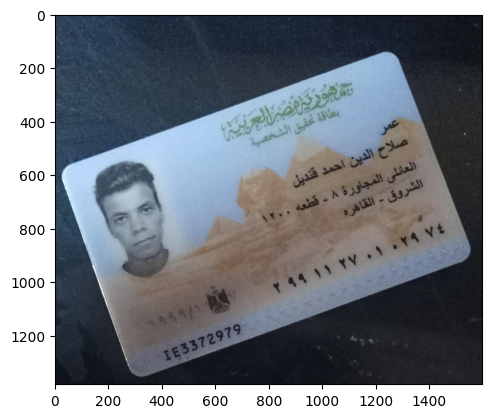

In [ ]:
path = '/content/gdrive/MyDrive/test_images/ID_2.jpg'
image = cv2.imread(path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
def ID_detection(image):

    global ID_contour

    # the default contour is the whole image, if the the sides of ID are the sides of the image
    ID_contour = np.array([[0, 0], [WIDTH, 0], [WIDTH, HEIGHT], [0, HEIGHT]])

    # converting the image into grayscale then applying Gaussian bluring to obtain the threshold
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blured_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    _, threshold = cv2.threshold(blured_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Detect the contours after specifying the threshold
    contours, _ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #sorting the detected contours in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Searching for the largest closed contour in the image

    '''calculated the area of each contour then got the perimeter of each contour
       for simplifying the shape. if the shape has 4 sides and
       a larger area than the maxmimum area, then it is an ID.
    '''
    max_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:
            # Get the perimeter of each contour
            peri = cv2.arcLength(contour, True)
            # simplifying the shape to check it has 4 sides or not
            approx = cv2.approxPolyDP(contour, 0.015 * peri, True) # (True) specifies that the contour is a closed contour
            if area > max_area and len(approx) == 4:
                ID_contour = approx
                max_area = area

    cv2.drawContours(image, [ID_contour], -1, (0, 255, 0), 3)


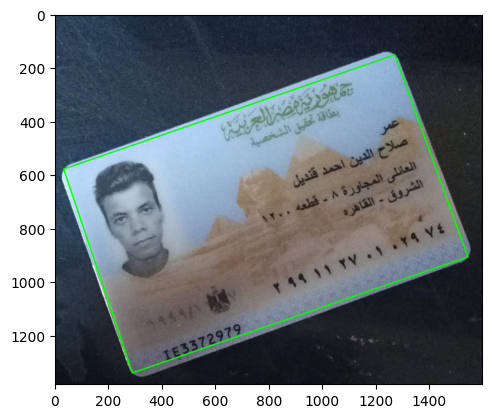

In [ ]:
ID_detection(image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

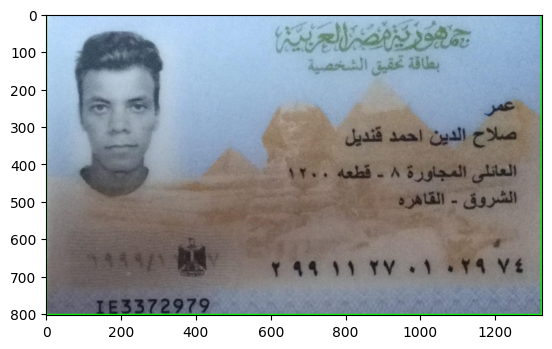

In [ ]:
# for detecting rotation and correcting it, used 'four_point_transform' function

'''(four_point_transform) function uses the cv2.getPerspectiveTransform
   and cv2.warpPerspective functions to perform the perspective transformation,
   calculates the perspective transform matrix and applies the perspective transform
    to correct the rotation of the ID and crop the detected ID from the image.
    It takes the image and the ID's contour as input parameters
'''
ID_Img = four_point_transform(image, ID_contour.reshape(4, 2))
plt.imshow(cv2.cvtColor(ID_Img, cv2.COLOR_BGR2RGB))

In [ ]:
# saving the detected ID image on Google Drive
cv2.imwrite('/content/gdrive/MyDrive/test_images/Detected_ID.jpg', ID_Img)

True

In [ ]:
!pip install ultralytics==8.0.196

import ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 3.9 MB/s eta 0:00:00


## After training YOLOv8m-seg model in a separate notebook, saved the weights to use it for segmenting text in the detected ID

In [ ]:
'''
specify the task as 'segment' task
choose the 'predict' mode
specify the weights and image paths
Assign the save parameter to true for saving the predicted image

'''
!yolo task=segment mode=predict model=/content/gdrive/MyDrive/Task_1/backup/best.pt conf=0.25 source=/content/gdrive/MyDrive/test_images/Detected_ID.jpg save=true

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27224700 parameters, 0 gradients, 110.0 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/gdrive/MyDrive/test_images/Detected_ID.jpg: 416x640 1 Address, 1 Birth, 1 ID, 1 Name, 213.1ms
Speed: 9.9ms preprocess, 213.1ms inference, 1165.3ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


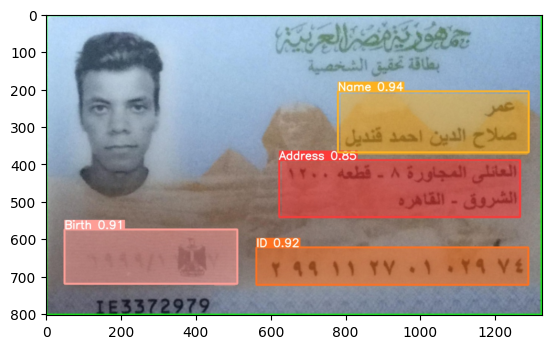

In [ ]:
segmented_ID = cv2.imread ('/runs/segment/predict/Detected_ID.jpg')
plt.imshow(cv2.cvtColor(segmented_ID, cv2.COLOR_BGR2RGB))

In [ ]:
model = YOLO ('/content/gdrive/MyDrive/Task_1/backup/best.pt')
results = model ('/content/gdrive/MyDrive/test_images/Detected_ID.jpg')


image 1/1 /content/gdrive/MyDrive/test_images/Detected_ID.jpg: 416x640 1 Address, 1 Birth, 1 ID, 1 Name, 34.0ms
Speed: 3.1ms preprocess, 34.0ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 640)


In [ ]:
# getting the data of the predicted segmentations
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([3., 2., 1., 0.], device='cuda:0')
conf: tensor([0.9428, 0.9189, 0.9128, 0.8453], device='cuda:0')
data: tensor([[7.8001e+02, 2.0673e+02, 1.2905e+03, 3.6909e+02, 9.4282e-01, 3.0000e+00],
        [5.6208e+02, 6.2357e+02, 1.2898e+03, 7.2322e+02, 9.1895e-01, 2.0000e+00],
        [4.9078e+01, 5.7549e+02, 5.1123e+02, 7.2077e+02, 9.1275e-01, 1.0000e+00],
        [6.2312e+02, 3.9082e+02, 1.2679e+03, 5.4259e+02, 8.4532e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (804, 1326)
shape: torch.Size([4, 6])
xywh: tensor([[1035.2574,  287.9097,  510.4937,  162.3530],
        [ 925.9369,  673.3933,  727.7108,   99.6458],
        [ 280.1566,  648.1302,  462.1564,  145.2743],
        [ 945.5062,  466.7049,  644.7674,  151.7783]], device='cuda:0')
xywhn: tensor([[0.7807, 0.3581, 0.3850, 0.2019],
        [0.6983, 0.8376, 0.5488, 0.1239],
        [0.2113, 0.8061, 0.3485, 0.1807],
        [0.7131, 0.5805, 0.4862

In [ ]:
# Extracting bounding boxes coordinates
boxes = results[0].boxes.xyxy.tolist()

In [ ]:
boxes

[[780.0106201171875,
  206.73316955566406,
  1290.5042724609375,
  369.0861511230469],
 [562.0814819335938, 623.5704345703125, 1289.792236328125, 723.2161865234375],
 [49.078346252441406, 575.4930419921875, 511.2347412109375, 720.767333984375],
 [623.1224975585938, 390.8157958984375, 1267.889892578125, 542.5940551757812]]

In [ ]:
# function to crop the segmented texts from the IDs
def crop_segmentations_from_ID (img_path, bounding_boxes):

    original_image = cv2.imread(img_path)

    i=0 # iterator for plotting all the cropped text lines

    # Iterate over each bounding box in the list
    for box in bounding_boxes:
        x1, y1, x2, y2 = map(int, box) # convert the floating numbers of coordinates into integers

        # Cropping the text image from the ID
        cropped_region = original_image[y1:y2, x1:x2]

        # Plotting all the cropped text images
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 2, i+1)
        plt.imshow(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))


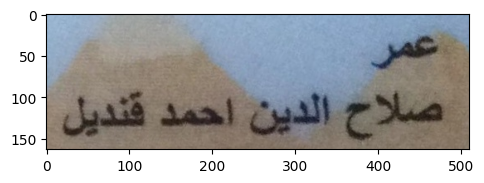

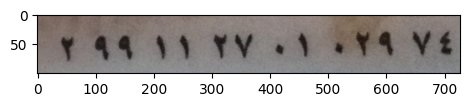

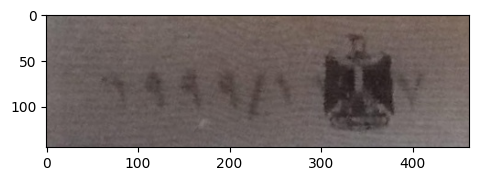

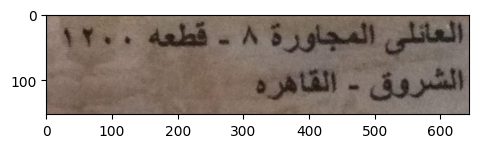

In [ ]:
Detected_ID = '/content/gdrive/MyDrive/test_images/Detected_ID.jpg'
crop_segmentations_from_ID (Detected_ID, boxes)